
[Hold-out] 2024-07-31 → 2025-06-30 | lags=1 | AIC=-8.685

Total guest nights
  RMSE : 1,189,324.578
  MAE  : 878,028.755
  MAPE : 6.417%
  sMAPE: 6.296%

International guest nights
  RMSE : 551,022.798
  MAE  : 435,416.462
  MAPE : 8.651%
  sMAPE: 9.169%

Domestic guest nights
  RMSE : 1,169,480.016
  MAE  : 666,863.203
  MAPE : 7.738%
  sMAPE: 7.181%

[VAR] selected lags=1 | AIC=-9.346

Forecast results saved to: ../output/Model_02_VAR_ADP.csv


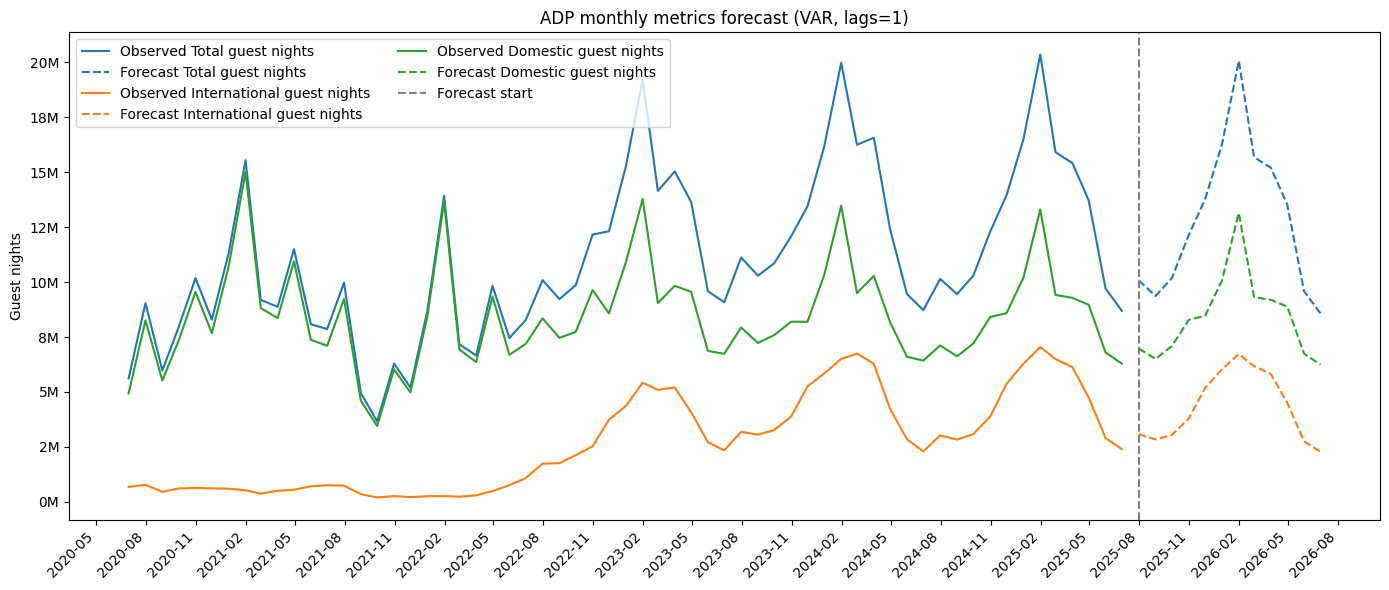

In [2]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.api import VAR

# ----------------------- Config -----------------------
ADP_CSV = "../datasets/ADP_All_Measures.csv"

HORIZON = 12
MAX_LAGS = 6
HOLDOUT_STEPS = 12

SERIES = [
    "Total guest nights",
    "International guest nights",
    "Domestic guest nights",
]

# ----------------------- Helpers -----------------------
def full_month_range(idx):
    start = pd.to_datetime(idx.min()) + MonthEnd(0)
    end = pd.to_datetime(idx.max()) + MonthEnd(0)
    return pd.date_range(start=start, end=end, freq="ME")

def configure_ax(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

def print_banner(s):
    bar = "=" * len(s)
    print(f"\n{bar}\n{s}\n{bar}")

# ----------------------- Load & Aggregate ADP -----------------------
def load_adp_national(adp_csv: str) -> pd.DataFrame:
    adp = pd.read_csv(adp_csv)
    adp["Month"] = pd.to_datetime(adp["Month"], format="%Y-%m-%d", errors="coerce")
    adp["Date"] = adp["Month"] + MonthEnd(0)

    if "Total guest nights" not in adp.columns:
        if {"Domestic guest nights", "International guest nights"}.issubset(adp.columns):
            adp["Total guest nights"] = (
                adp["Domestic guest nights"] + adp["International guest nights"]
            )
        else:
            raise ValueError("Missing both 'Total guest nights' and components to construct it.")

    g = adp.groupby("Date")[SERIES].sum(min_count=1).sort_index()
    idx = full_month_range(g.index)
    g = g.reindex(idx).ffill().bfill()
    return g

# ----------------------- Transformations -----------------------
def forward_transform(df: pd.DataFrame):
    z = np.log1p(df)
    mu, sd = z.mean(), z.std(ddof=0).replace(0, 1.0)
    z_std = (z - mu) / sd
    return z_std, {"mu": mu, "sd": sd}

def inverse_transform(z_std: pd.DataFrame, meta: dict):
    z = z_std * meta["sd"] + meta["mu"]
    return np.expm1(z).clip(lower=0)

# ----------------------- Differencing & reintegration -----------------------
def seasonal_diff(df: pd.DataFrame, s: int = 12) -> pd.DataFrame:
    return df - df.shift(s)

def seasonal_undiff(history: pd.DataFrame, diffs: pd.DataFrame, s: int = 12) -> pd.DataFrame:
    hist = history.copy()
    for t in diffs.index:
        anchor = t - pd.DateOffset(months=s)
        if anchor in hist.index:
            level_t = hist.loc[anchor] + diffs.loc[t]
        else:
            level_t = hist.iloc[-1] + diffs.loc[t]
        hist.loc[t] = level_t
    return hist.loc[diffs.index]

# ----------------------- Fit VAR with lag selection -----------------------
def fit_var_forecast(z_std: pd.DataFrame, horizon: int, max_lags: int = 6):
    z_diff = seasonal_diff(z_std, 12).dropna()
    if len(z_diff) < 24:
        raise ValueError("Not enough observations after seasonal differencing.")

    # Order selection with BIC; cap lags for stability
    try:
        ordsel = VAR(z_diff).select_order(max_lags)
        pick = ordsel.selected_orders.get("bic") or ordsel.selected_orders.get("aic") or 1
        lags = int(min(max(int(pick), 1), 3))
    except Exception:
        lags = 1

    # Fit without constant on differences; fallback to smaller lags if unstable
    while lags >= 1:
        res = VAR(z_diff).fit(lags, trend="n")
        if getattr(res, "is_stable", True):
            break
        lags -= 1
    if lags < 1:
        raise RuntimeError("Failed to obtain a stable VAR.")

    fc_diff_vals = res.forecast(y=z_diff.values[-lags:], steps=horizon)
    fc_diff = pd.DataFrame(
        fc_diff_vals,
        index=pd.date_range(z_diff.index[-1] + MonthEnd(1), periods=horizon, freq="ME"),
        columns=z_diff.columns,
    )

    fc_levels_std = seasonal_undiff(history=z_std, diffs=fc_diff, s=12)
    return res, fc_levels_std, lags

# ----------------------- Metrics -----------------------
def _rmse(a, f):
    return float(np.sqrt(np.mean((a - f) ** 2)))

def _mae(a, f):
    return float(np.mean(np.abs(a - f)))

def _mape(a, f):
    a, f = np.asarray(a, dtype=float), np.asarray(f, dtype=float)
    mask = a != 0
    return float(np.mean(np.abs((a[mask] - f[mask]) / a[mask])) * 100) if mask.any() else np.nan

def _smape(a, f):
    a, f = np.asarray(a, dtype=float), np.asarray(f, dtype=float)
    denom = np.abs(a) + np.abs(f)
    mask = denom != 0
    return float(np.mean(2 * np.abs(a[mask] - f[mask]) / denom[mask]) * 100) if mask.any() else np.nan

def print_metrics_block(title, actual: pd.Series, forecast: pd.Series):
    print_banner(title)
    print(f"  RMSE : {_rmse(actual, forecast):,.3f}")
    print(f"  MAE  : {_mae(actual, forecast):,.3f}")
    print(f"  MAPE : {_mape(actual, forecast):.3f}%")
    print(f"  sMAPE: {_smape(actual, forecast):.3f}%")

# ----------------------- Hold-out evaluation -----------------------
def evaluate_holdout(g: pd.DataFrame, holdout_steps: int = HOLDOUT_STEPS):
    if len(g) < (holdout_steps + 36):
        holdout_steps = max(6, len(g) - 36)
    if holdout_steps <= 0:
        return

    train_g, test_g = g.iloc[:-holdout_steps], g.iloc[-holdout_steps:]
    z_std_train, meta_train = forward_transform(train_g)

    res, fc_levels_std, lags = fit_var_forecast(z_std_train, holdout_steps, max_lags=MAX_LAGS)
    fc_levels = inverse_transform(fc_levels_std, meta_train).reindex(test_g.index)

    print_banner(
        f"[Hold-out] {test_g.index[0].date()} → {test_g.index[-1].date()} | lags={lags} | AIC={res.aic:.3f}"
    )
    for col in SERIES:
        print_metrics_block(col, test_g[col], fc_levels[col])

# ----------------------- Main -----------------------
def main():
    g = load_adp_national(ADP_CSV)

    # Holdout performance (metrics only)
    evaluate_holdout(g, holdout_steps=HOLDOUT_STEPS)

    # Fit on full data & future forecast
    z_std, meta = forward_transform(g)
    res, fc_levels_std, lags = fit_var_forecast(z_std, HORIZON, MAX_LAGS)
    fc_levels = inverse_transform(fc_levels_std, meta)

    start_fc = fc_levels.index[0]
    observed = g.copy()

    print_banner(f"[VAR] selected lags={lags} | AIC={res.aic:.3f}")

    # Save forecast
    out_csv = "../output/Model_02_VAR_ADP.csv"
    fc_levels_rounded = fc_levels.round(0).astype(int)
    fc_levels_rounded.index.name = "Date"
    fc_levels_rounded.to_csv(out_csv)
    print(f"\nForecast results saved to: {out_csv}")

    # Combined plot (future only)
    plt.figure(figsize=(14, 6))
    colors = {
        "Total guest nights": "#1f77b4",
        "International guest nights": "#ff7f0e",
        "Domestic guest nights": "#2ca02c",
    }
    for col in SERIES:
        plt.plot(observed.index, observed[col], label=f"Observed {col}", color=colors[col])
        plt.plot(
            fc_levels.index,
            fc_levels[col],
            linestyle="--",
            label=f"Forecast {col}",
            color=colors[col],
        )

    plt.axvline(start_fc, color="gray", linestyle="--", label="Forecast start")
    plt.title(f"ADP monthly metrics forecast (VAR, lags={lags})")
    plt.ylabel("Guest nights")
    plt.legend(loc="upper left", ncol=2, frameon=True)
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x*1e-6:,.0f}M"))
    configure_ax(plt.gca())
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
